In [2]:
import numpy as np
import pandas as pd

获取GLA的meta信息

In [3]:
ca_meta = pd.read_csv('../LargeST/data/ca/ca_meta.csv')
# get different districts
gla_meta = ca_meta[(ca_meta.District == 7) | (ca_meta.District == 8) | (ca_meta.District == 12)]
gla_meta = gla_meta.reset_index()
gla_meta = gla_meta.drop(columns=['index'])
gla_meta.to_csv('gla_meta.csv', index=False)
print(gla_meta[gla_meta.duplicated(subset=['Lat', 'Lng'])])
gla_meta

Empty DataFrame
Columns: [ID, Lat, Lng, District, County, Fwy, Lanes, Type, Direction, ID2]
Index: []


,ID,Lat,Lng,District,County,Fwy,Lanes,Type,Direction,ID2
0,767494,34.103332,-118.249733,7,Los Angeles,SR2-E,3,Mainline,E,3527
1,767509,34.107693,-118.249538,7,Los Angeles,SR2-E,4,Mainline,E,3528
2,767523,34.113959,-118.242956,7,Los Angeles,SR2-E,4,Mainline,E,3529
3,767541,34.116060,-118.238384,7,Los Angeles,SR2-E,4,Mainline,E,3530
4,767554,34.121074,-118.229892,7,Los Angeles,SR2-E,4,Mainline,E,3531
...,...,...,...,...,...,...,...,...,...,...
3829,1202527,33.800970,-118.082822,12,Orange,I605-N,4,Mainline,N,8595
3830,1202549,33.804853,-118.081293,12,Orange,I605-N,4,Mainline,N,8596
3831,1219560,33.799259,-118.084891,12,Orange,I605-S,5,Mainline,S,8597
3832,1202522,33.801040,-118.083136,12,Orange,I605-S,4,Mainline,S,8598


# 名词解释

* District: The district of a sensor in PeMS.
* Country: The country of a sensor in California.
* Fwy: The highway where a sensor is located.
* Lane: The number of lanes where a sensor is located。
* Direction: The direction of the highway.

## Filtering sensors

* We remove some redundant detectors to ensure the distance between any adjacent detectors is longer than 3.5 miles; (ASTGCN)
* the location shifting of a sensor in corresponding metadata should be less than 100 meters; (TrafficStream)
* the missing ratio of data of a sensor should be less than 15%;

### 1. filtering sensors by distance

In [4]:
from math import radians, sin, cos, sqrt, atan2

def haversine_distance(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    R = 6371.0

    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    # Calculate the distance
    distance = R * c

    return distance

In [5]:
gla_meta.shape

(3834, 10)

共有3834个传感器

之前思路是：
1. 筛选第7区的传感器；
2. 选择地理上的中心节点（大概的）；
3. 根据中心节点稀疏化传感器分布，使其两两之间距离大于2km；
4. 滤除缺失率较高的传感器。

修改后的思路是：

（扩增的变量尽可能是流量比较大的点，预测难度加大）
1. 取得具有较大流量的传感器ID，后续用于判断；
2. 以中心传感器为中心，筛选出来一批，大概300+个传感器为第一阶段，这里不探究是否是大流量；
3. 然后再往周围扩散，特别选择大流量的传感器。

In [6]:
loc_dict = {}

# get the metadata of the sensors located in district 7.
for idx, row in gla_meta.iterrows():
    if row['District'] == 7:
        value = {"id": row['ID'], "lat": row['Lat'], "lng": row['Lng']}
        loc_dict[idx] = value

# initial a matrix to store the distance between paired sensors
dis_matrix = np.zeros((len(loc_dict), len(loc_dict)))

for i in range(len(loc_dict)):
    for j in range(i+1, len(loc_dict)):
        s1_loc = (loc_dict[i]['lat'], loc_dict[i]['lng'])
        s2_loc = (loc_dict[j]['lat'], loc_dict[j]['lng'])
        dis_matrix[i][j] = haversine_distance(s1_loc[0], s1_loc[1], s2_loc[0], s2_loc[1])

dis_matrix = np.tril(dis_matrix.T) + dis_matrix
dis_matrix[:4, :4]

array([[0.        , 0.48525332, 1.33627713, 1.75919264],
       [0.48525332, 0.        , 0.92339236, 1.38565947],
       [1.33627713, 0.92339236, 0.        , 0.48138663],
       [1.75919264, 1.38565947, 0.48138663, 0.        ]])

得到距离矩阵，其中矩阵下标对应的传感器可以在loc_dict字典中查询。其中key表示下标，value包含了传感器号、经纬度。

In [7]:
# 得到中心传感器号的经纬度，传感器号
gla_meta.iloc[551]

ID                717262
Lat             34.02902
Lng          -118.216326
District               7
County       Los Angeles
Fwy               SR60-E
Lanes                  3
Type            Mainline
Direction              E
ID2                 4078
Name: 551, dtype: object

In [8]:
dis_matrix.shape

(1859, 1859)

稀疏化传感器，使其两两之间保有2km的长度。

In [9]:
# filtering sensor to ensure the distance between any adjacent sensors longer than 3 miles. (how to judge adjacent)

center = 551
_range = 2 # unit: km
candidate = [551]
i = 0

while i < len(candidate):
    tmp = np.where((_range < dis_matrix[candidate[i]]) & (dis_matrix[candidate[i]] < 2 * _range))[0]
    # let new one in candidate
    for c in tmp:
        if c in candidate:
            continue
        else:
            # new one should be {_range}km away from the existing nodes 
            if sum(dis_matrix[c][candidate] < _range) > 1:
                continue
            else:
                # if meet all conditions
                candidate.append(c)
    i += 1

len(candidate)

468

筛选得到468个传感器，其中存储的是全部传感器号排列的下标。

#### recheck the condition

In [10]:
sum(dis_matrix[candidate, candidate] < _range)

468

### 2. filtering sensors by missing ratio

ca_rn_adj is the normalization matrix by distance

In [12]:
# load dataset
df = pd.read_hdf("../LargeST/data/ca/ca_his_raw_2017.h5")
df.head(1)

,317802,312134,312133,313159,319767,319780,317830,314876,314886,314909,...,1221523,1221550,1221536,1221556,1219551,1202527,1202549,1219560,1202522,1202537
Time,,,,,,,,,,,,,,,,,,,,,
2017-01-01,57.0,19.0,17.0,29.0,31.0,47.0,73.0,27.0,30.0,37.0,...,NaN,NaN,NaN,NaN,47.0,0.0,43.0,40.0,62.0,81.0


In [13]:
ID = [str(loc_dict[c]['id']) for c in candidate]

gla_his = df[ID]

In [14]:
del df

In [15]:
missing_ratio = gla_his.isnull().mean()
missing_ratio

717262    0.000152
716933    0.000152
759566    0.000143
716942    0.000162
716940    0.000152
            ...   
717554    0.000133
771329    0.000133
771340    0.000162
764900    0.000143
764905    0.000152
Length: 468, dtype: float64

In [16]:
missing_ratio[missing_ratio > 0.15].index

Index(['776752', '776290', '776196', '776289', '776266', '776826', '776518',
       '775825', '776020', '769228', '773785', '776081', '776066', '776060',
       '776073', '776313', '776457'],
      dtype='object')

delete these 17 sensors which missing ratio greating than 0.15.

In [17]:
missing_list = missing_ratio[missing_ratio > 0.15].index.tolist()

In [18]:
filter_sensor = list(set(ID) - set(missing_list))
print(len(filter_sensor))

451


进一步筛选后，得到451个传感器

### 3.filtering sensors by the time range

plot a line chart to view changes in data

<Axes: xlabel='Time'>

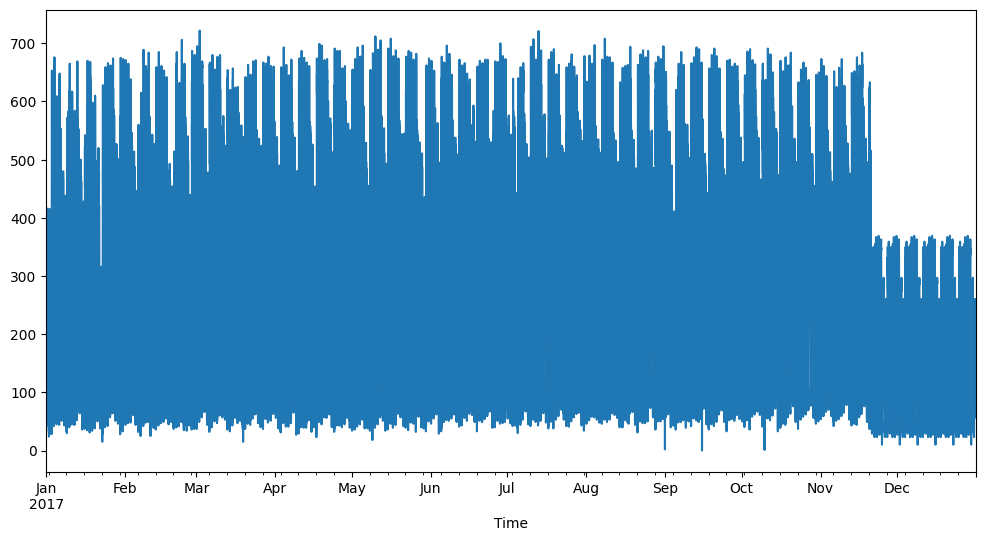

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt


filter_gla_his = gla_his[filter_sensor]
plt.figure(figsize=(12,6))
filter_gla_his['717963'].plot()

In [71]:
filter_gla_his.keys()[380]

'767367'

### 因为一些变量存在时序漂移，并且漂移的问题是出现在测试集上，在训练集上没有体现。如果是解决漂移问题，至少在训练集上应该是有一些的。

<Axes: xlabel='Time'>

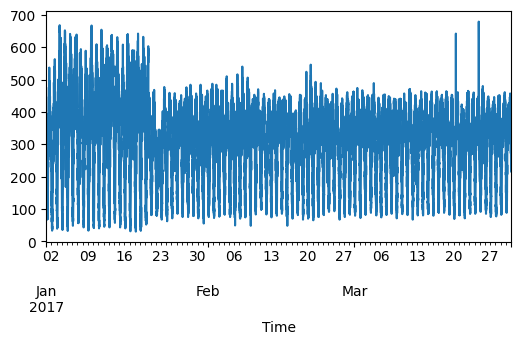

In [72]:
plt.figure(figsize=(6,3))
filter_gla_his['767367']["2017-01-01":"2017-03-30"].plot()

the data is truncated from Jan, 2017 to March, 2017.

生成上述传感器之间的空间距离矩阵

center node: 717262

In [19]:
columns = filter_gla_his.columns.tolist()

* columns中存储的是传感器ID；
* loc_dict存储的是距离矩阵中下标与ID的对应关系；

要获取columns中传感器的距离矩阵。

In [20]:
columns[:3]

['717543', '767760', '763563']

In [21]:
ID2idx = {}
for k, v in loc_dict.items():
    _id = v['id']
    ID2idx[str(_id)] = k

idx_columns = [ID2idx[c] for c in columns]

id2idx中下标是未筛选前的终端编号，也就是columns中的终端编号及其下标。

In [22]:
idx_columns[:3]

[1164, 1075, 519]

In [23]:
dis_adj = dis_matrix[idx_columns][:, idx_columns]

当前距离矩阵中是按照451个终端的顺序排序，其下标和终端编号的对应。

考虑到扩增变量的使用方便，将数据以及距离矩阵的顺序按照扩增的顺序排放。

In [24]:
# 根据columns的ID号，重新计划距离矩阵

id2idx = {} # ID TO index
idx2id = {} # Index to ID

for i, c in enumerate(columns):
    id2idx[c] = i
    idx2id[i] = c

In [25]:
# 180是中心传感器在距离矩阵的位置， 这里是选择前371传感器。
p1_sensor_array = np.argsort(dis_adj[180])[:371]

In [26]:
p1_sensor_array[:30]

array([180, 202, 362, 204, 449, 441, 443, 404,   0, 108,  14, 118, 445,
       414, 280, 286, 412, 164,  32, 189, 137, 301,  47, 370, 229, 251,
       323, 171,  26, 330])

p1_sensor_array中存储的是371传感器，它们和中心传感器的距离为41公里以内。剩余新扩张的451-371个传感器是大于41公里的。

按照p1_sensor_array对应的顺序重新排列距离矩阵dis_adj、csv数据，这样让新扩增的传感器都位于旧的之后。

In [28]:
# 将第二阶段的传感器追加在后面

new_columns_idx = p1_sensor_array.tolist()
# 获得ID的集合，用于reassign数据

new_columns_id = [idx2id[idx] for idx in new_columns_idx]

In [29]:
len(new_columns_id), len(new_columns_idx)

(371, 371)

In [30]:
len(columns)

451

In [31]:
for i in range(0, len(columns)):
    if i not in new_columns_idx:
        new_columns_id.append(idx2id[i])
        new_columns_idx.append(i)

In [32]:
len(new_columns_id), len(new_columns_idx)

(451, 451)

In [33]:
446 in new_columns_idx

True

In [34]:
new_columns_idx[:5]

[180, 202, 362, 204, 449]

In [35]:
dis_adj = dis_adj[new_columns_idx, :]
dis_adj = dis_adj[:, new_columns_idx]

In [36]:
# reorder dataframe
filter_gla_his = filter_gla_his[new_columns_id]

In [38]:
filter_gla_his.keys()

Index(['765995', '771706', '765978', '766012', '717525', '766029', '772487',
       '717568', '717543', '717544',
       ...
       '774813', '717226', '774958', '718053', '759980', '775101', '774475',
       '764217', '717701', '769292'],
      dtype='object', length=451)

记录下标与ID的对应关系，记录ID的经纬度。

In [39]:
ID_POS = {}

for idx, row in gla_meta.iterrows():
    value = {"lat": row['Lat'], "lng": row['Lng']}
    ID_POS[str(row['ID'])] = value

In [40]:
dis_adj.shape, len(new_columns_idx)

((451, 451), 451)

In [41]:
len(new_columns_id)

451

In [42]:
sensor_meta = {}

for idx in range(dis_adj.shape[0]):
    sensor_meta[idx] = {
        "ID": new_columns_id[idx],
        "lat": ID_POS[new_columns_id[idx]]['lat'],
        "lng": ID_POS[new_columns_id[idx]]['lng']
    }

In [43]:
df = filter_gla_his["2017-01-01":"2017-03-31"]
print(df.isnull().sum().sum())

df = df.interpolate()
df = df.ffill()
df = df.bfill()
print(df.isnull().sum().sum())

35801
0


In [45]:
df.keys()

Index(['765995', '771706', '765978', '766012', '717525', '766029', '772487',
       '717568', '717543', '717544',
       ...
       '774813', '717226', '774958', '718053', '759980', '775101', '774475',
       '764217', '717701', '769292'],
      dtype='object', length=451)

In [46]:
# save file during Jan. -- March
df.to_csv("./gla_pemsd7.csv", index=True)

In [47]:
np.save("./gla_dis.npy", dis_adj)

In [48]:
import json
with open("./sensor_meta.json", "w") as file:
    json.dump(sensor_meta, file)

In [49]:
dis_adj[180, 354]

26.64264015545617

大于41公里的传感器

In [47]:
sensor_meta[445]

{'ID': '771253', 'lat': 34.179522, 'lng': -118.86008000000001}

In [48]:
dis_adj.shape

(451, 451)

In [49]:
sensor_meta[446]

{'ID': '717243', 'lat': 34.072839, 'lng': -117.77926399999998}

In [50]:
%matplotlib inline

import folium


my_map = folium.Map(zoom_start=4)

for idx in range(371):
    coordinates = (sensor_meta[idx]['lat'], sensor_meta[idx]['lng'])
    folium.Marker(location=coordinates, icon=folium.Icon(color="blue")).add_to(my_map)

for idx in range(371, dis_adj.shape[0]):
    coordinates = (sensor_meta[idx]['lat'], sensor_meta[idx]['lng'])
    folium.Marker(location=coordinates, icon=folium.Icon(color="red")).add_to(my_map)


my_map.save('../Spatio-temporal-Incremental-Learning/Analysis/map_with_marker.html')

In [ ]:
sensor_meta[450]

{'ID': '762353', 'lat': 33.890696999999996, 'lng': -118.041009}